<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(vanilla_gan_mnist.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

# Building a Simple GAN - Understanding GANs   

### Lab Objectives:   
- Build a simple Generative Adversarial Network (GAN) to help us understand how we can use this for generating fake content. 
- Learn that these fake content can be anything. For example, a threat actor may be able to generate fakes that that mimics your training data. Maybe  generate fake faces that bypasses facial detection tools. Maybe generate fraudulent transactions that are seen as legitimate by monitoring tools.  
- Get the basics of GANs
- Learn that all of the above requires the the data available to train the GAN, is representative of the problem being solved or the attack being attempted     

https://arxiv.org/pdf/1406.2661
https://www.youtube.com/watch?v=HGYYEUSm-0Q   
https://github.com/gordicaleksa/pytorch-GANs/blob/master/Vanilla%20GAN%20(PyTorch).ipynb  

### Lab Objectives:   
- Learn what GANs are and how they work   
- Leverage the MNIST built in dataset to as the source of our data
- Understand how a threat actor may be able to use a GAN to generate fake samples. These can be anything of interest to the threat actor.     
- Understand that a GAN consist of two networks a generator and a discriminator  
- Use a trained generator model to generate new content.   


### Step 1:  

In [1]:
# Let's start by importing our libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchinfo
from torchvision.transforms import v2

# We will use an existing dataset to keep this concept simple
from torchvision.datasets import MNIST
import netron
import IPython
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter   # Need this to visualize the progression of the learning
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

2025-08-01 21:44:04.680820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 21:44:05.015484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754099045.133737   19393 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754099045.171931   19393 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754099045.405845   19393 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchinfo version used:  {torchinfo.__version__}')
print(f'Netron version used:  {netron.__version__}')


Torch version used:  2.7.1+cu128
Torchinfo version used:  1.8.0
Netron version used:  8.4.4


In [3]:
# GANs can be very computational expensive to train, hence, let's make the code device agnostic

# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


When working with neural networks. We have a number of hyperparameters to define, based on the type of architecture we will be using. For us, we will be using Linear Layers.  

- The input dimension for our generator will be 100. 
- To keep things simple as always, we use grayscale image. This means rather than RGB with 3 channels, we instead have 1.  
- Our image size will be 28x28
- We define our batch size as 128. This is the amount of samples we will process in one go. Earlier we learned about datasets and dataloaders in the **dataset_dataloader.ipynb** notebook. As a result, the expectation is you have a solid understanding of what is being done here.  
- Just for simplicity, we will train for 25 epochs 
- We will set our learning rate to 0.0002. This is an important hyperparameter and can make or break your GAN.  
- We set the adam_beta1 to 0.5 
- We specify our hidden layers as 256. We can expand and or reduce on this as we go forward.   

In [4]:
# Define the hyperparameters for the discriminator and generator
z_dim = 100
img_chnl = 1  # We will be using black and white images, hence 1 channel
img_sz = 28
batch_sz = 128
n_epochs = 25
lr = 0.0002         # Try setting this to 0.1 and see what happens ;-) 
adam_beta1 = 0.5
hidden_layers = 256

# Image directory
img_dir = r'/tmp/mnist_data/'

In [5]:
# Setup the transform for the image
# This is needed as we need to transform the image for the network
transform = v2.Compose(transforms=[
    v2.ToImage(),   # We need to convert the tensors to an image
    v2.ToDtype(dtype=torch.float32, scale=True), # Sets the datatype to float32
    v2.Normalize(mean=[.5], std=[.5])   # normalize to a mean and standard deviation of .5
])

The MNIST dataset is being used, so that we have something we can all work though. This concept however applies to any dataset.  

### Step 2:  

In [6]:
# Get the training data
# Note we apply the transform created above on the MNIST data here.  
X_real_train_images = MNIST(root=img_dir, train=True, download=True, transform=transform)
X_real_train_images

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 772kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 7.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.33MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: /tmp/mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [7]:
# Get the length of the dataset
print(f'The dataset consists of: *{len(X_real_train_images)}* samples')

The dataset consists of: *60000* samples


In [8]:
# Setup the dataloader
# When using very large datasets, we need batch the data as it is being processed
# If not, trying to load the entire dataset into memory, may result in an out of memory error.
X_train_loader = DataLoader(dataset=X_real_train_images, batch_size=batch_sz, shuffle=True )
X_train_loader

In [9]:
# Get a sample batch:
# Notice images are now values between -1 and 1
# This is because we used we normalize the data in the transform with *v2.Normalize(mean=[.5], std=[.5]*
# Also there are labels. We don't need these labels as this is an unsupervised learning problem. 
sample_batch = next(iter(X_train_loader))
sample_batch

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [10]:
# Get the shape of the first bach.
# No surprises here, we have 128 items with 1 channel and 28 pixels high and 28 pixels wide. 
sample_batch[0].shape

torch.Size([128, 1, 28, 28])

In [11]:
# Looking at the labels
# No surprises here, we have 128 labels
sample_batch[1].size()

torch.Size([128])

As always, we visualize the data before attempting to build any models. 

### Step 3:   

In [12]:
# Plot a few of the images
# While those images can be viewed in colour, we have to remember our img_chnls variable above is assigned 1 (img_chnls = 1), hence this is a grayscale image
# We did this in the previous lab. 
# Just keeping it here if you wish to use it.
# Just uncomment the lines if needed
# Then again, each of these notebooks should be able to work on its own :-D 

def plot_images(image_src=None, label=None):
    fig = plt.figure(figsize=(10,5))
    for i in range(15):
        ax = fig.add_subplot(3,5,i+1)
        ax.set_title(label=f'{label[i]}' if label != None else ' ', fontdict={'size' : 20})
        ax.imshow(image_src[i].view(28,28), cmap='gray')
        ax.set_axis_off()

    plt.tight_layout()


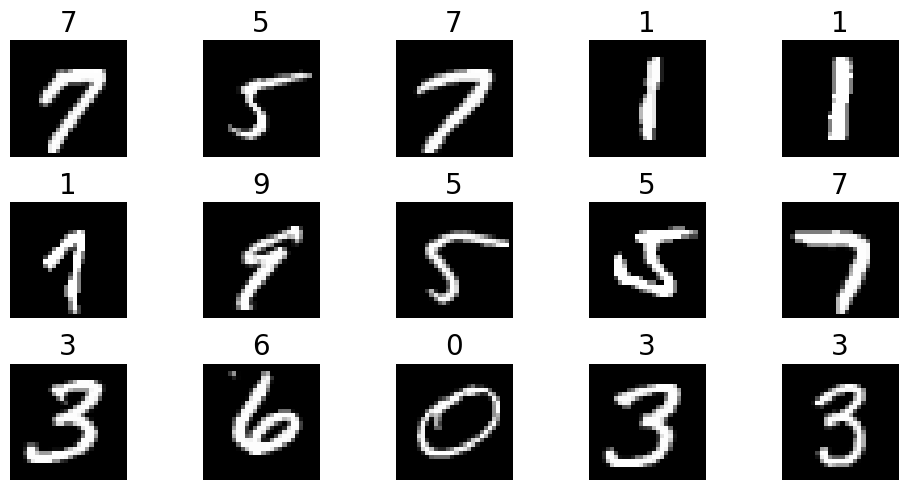

In [13]:
# Call the function to verify it works
# At the same time, verify some sample images and labels.
plot_images(image_src=sample_batch[0], label=sample_batch[1])

What makes GANs interesting, is their ability to generate real looking images, that are similar to the distribution they were trained on. 
The generator is responsible for generating these fake images that looks like real images, thus having the discriminator classify them as real images. 
In GANs, both the generaztor and discriminator are trained together from scratch, providing feedback to each other, allowing each other to get better as the training progresses.    


<img  style="max-width:200em; height:auto;" src="../graphics/gan.png"/><br>
Source: https://arxiv.org/pdf/1810.00069  

Let's start this off by building the generator portion of the our simple GAN first.   

### Step 4:  

In [14]:
# Freeze the random number generator for reproducibility   
# This ensures your results and mine should be the same
torch.manual_seed(10)

# Generate a random batch of images similar to the true images
# This is just basically noise. Nothing meaningful here
# The objective is for the discriminator to learn how to take this noise
# and make it into something meaningful
# Remember that batch_sz and z_dim were defined at the beginning of this notebook
sample_noise = torch.randn(size=(batch_sz, z_dim))
sample_noise, sample_noise.size()

(tensor([[-0.8173, -0.5556, -0.8267,  ...,  0.1044, -0.2538, -0.1487],
         [-0.5779, -1.6192, -0.2754,  ..., -1.1435,  0.3288,  0.2663],
         [ 0.0098, -0.4986, -1.1888,  ..., -2.7726, -1.0959, -0.3056],
         ...,
         [-0.9544,  1.2404,  1.3212,  ..., -0.7227,  1.2186,  0.5435],
         [-1.4290, -1.9125, -1.1208,  ...,  0.2695,  1.1976,  2.2226],
         [ 0.4091, -0.2238, -0.4885,  ..., -0.6951,  0.3432,  1.2117]]),
 torch.Size([128, 100]))

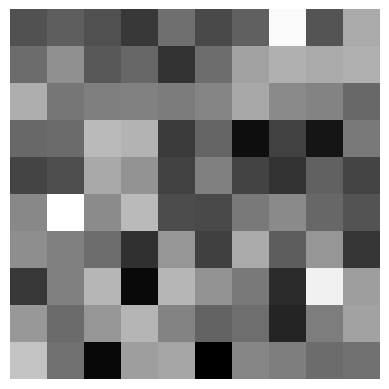

In [15]:
# Visualize the noise, using 1 sample
# Reshaping it as a 10x10 input for easy visualization
plt.imshow(sample_noise[0].view(10,10), cmap='gray')
plt.axis('off');

The generator starts from the above noise and must be able to produce images as seen earlier above of the numbers.  The objective is to learn via the training process, to move from this noise a valid number. Or in other cases a valid face, or whatever else the threat actor would like to generate.  

### Step 5:  

In [16]:
# Define the Generator class
# Remember the values used for z_dim, hidden_layers, etc., were defined above
class Generator(nn.Module):
    def __init__(self,):
        super(Generator, self).__init__()

        # Define the layers
        self.gen_layers = nn.Sequential(
            # We are using linear/dense layers
            nn.Linear(in_features=z_dim, out_features=hidden_layers, bias=True),

            # using the LeakyRelu activation function
            # This introduces non-linearity
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers * 2, bias=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(in_features=hidden_layers * 2, out_features=hidden_layers * 4, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(in_features=hidden_layers * 4, out_features=img_sz * img_sz),

            # The Tanh activation function is being used here 
            # to force the output to values between -1 and +1
            # If you go back to the top where we look at sample images
            # you see there are lots fo values of -1 and some with +1
            nn.Tanh()
        )

    def forward(self, z):
        # Apply the layers to our data
        z = self.gen_layers(z)
        return z

In [17]:
# Instantiate the Generator class
# The seed is set so that the weights you and I see are the same.
torch.manual_seed(seed=20)
g_model = Generator()

# See the model's parameters
g_model.state_dict()

# Get a look at the parameters count
torchinfo.summary(model=g_model, input_size=(1, z_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 784]                  --
├─Sequential: 1-1                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 256]                  25,856
│    └─LeakyReLU: 2-2                    [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 1024]                 524,288
│    └─LeakyReLU: 2-6                    [1, 1024]                 --
│    └─Linear: 2-7                       [1, 784]                  803,600
│    └─Tanh: 2-8                         [1, 784]                  --
Total params: 1,485,328
Trainable params: 1,485,328
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.94
Estimat

In [18]:
# Pass the sample noise created above to the generator
# This is just to ensure that we can pass our random noise in. 
g_model(sample_noise.to(device)).size()

torch.Size([128, 784])

Above suggests our generator is working. It has not been trained as yet, but we are still able to pass our noise to it without any errors being returned. Let us look at the computation graph with *netron*.

### Step 6:  

In [19]:
# Visualize the network
# Visualize the generator model
# Export the model
torch.onnx.export(model=g_model, args=sample_noise.to(device), f=r'/tmp/g_model.onnx.pth', dynamo=True, input_names=['z_random_noise'], output_names=['generated_image'])

# Load up the model via netron
netron.start(file=r'/tmp/g_model.onnx.pth', browse=False, address=('127.0.0.1', 8889))

# Visualize the model's computation graph inline of the notebook
IPython.display.IFrame('http://localhost:8889', width=700, height=700)


[torch.onnx] Obtain model graph for `Generator([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Generator([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Serving '/tmp/g_model.onnx.pth' at http://127.0.0.1:8889


With the model built and the architecture visualized, let us see how the untrained generator model does on our random noise. There should be no expectation of seeing anything meaningful such as a number. This is because the model has not learnt anything as yet.

### Step 7:  

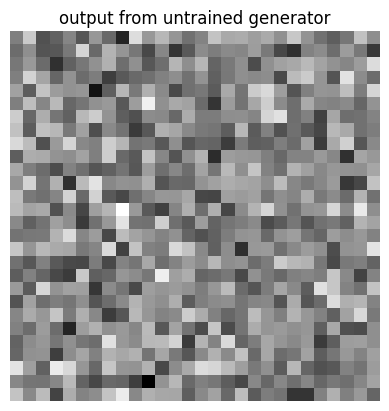

In [20]:
# Reshaping it as a 10x10 input for easy visualization
plt.title(label='output from untrained generator')
plt.imshow(g_model(sample_noise.to(device)).detach()[0].view(28,28).cpu(), cmap='gray')
plt.axis('off');

So we know the generator model works. Let us now build the discriminator. The Discriminator is used to inspect a sample and determines whether it is real or fake. Notice the sigmoid activation function at the end of our model in the last layer. In the generator, we used Tanh at the last layer. Because Sigmoid is used at the last layer, this means our final output is a probability  of value between 0 and 1. 1 being real images and 0 being fake images

### Step 8:  

In [21]:
# Setup the Discriminator
class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()

        # These layers are much the same as we saw earlier, except for the hyperparameter values
        self.dis_layers = nn.Sequential(
        nn.Linear(in_features=img_sz * img_sz, out_features=hidden_layers * 4, bias=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),

        # Dropout is used for regularization
        # We are going to disable 30% of the neurons in this layer
        nn.Dropout(p=0.3),
        
        nn.Linear(in_features=hidden_layers * 4, out_features=hidden_layers * 2, bias=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Dropout(p=0.3),
        
        nn.Linear(in_features=hidden_layers * 2, out_features=hidden_layers, bias=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Dropout(p=0.3),
        
        # Notice one neuron in the out_features?
        # This will represent the probability of the positive class
        # That is the probability of the sample being real or 1
        nn.Linear(in_features=hidden_layers, out_features=1),

        # Sigmoid gives us the probability
        nn.Sigmoid()
)

    def forward(self, x):
        x = self.dis_layers(x)
        return x

In [22]:
# Instantiate the Discriminator
torch.manual_seed(seed=20)
d_model = Discriminator()
d_model.state_dict()

# Get the parameters again
torchinfo.summary(model=d_model, input_size=(1, img_sz * img_sz))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─LeakyReLU: 2-2                    [1, 1024]                 --
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]                  524,800
│    └─LeakyReLU: 2-5                    [1, 512]                  --
│    └─Dropout: 2-6                      [1, 512]                  --
│    └─Linear: 2-7                       [1, 256]                  131,328
│    └─LeakyReLU: 2-8                    [1, 256]                  --
│    └─Dropout: 2-9                      [1, 256]                  --
│    └─Linear: 2-10                      [1, 1]                    257
│    └─Sigmoid: 2-11                     [1, 1]                    --

In [23]:
print(f'Currently the real sample data has shape: {sample_batch[0].size()}')

# We need to change the shape (flatten) this to pass to the linear layer
# This is because we are using dense/linear layers
# If we had convolutional layers like is being used in the lab on *dc_gan_mnist.ipynb*
# We could keep this shape.
print(f'Reshapeed input: {sample_batch[0].view(-1, 28 * 28).size()}')

sample_batch = sample_batch[0].view(-1, 28 * 28)


# With the input reshaped, we can pass it to the model
# We could test one sample
#d_model(sample_batch[0])

# or we look at a batch
d_model(sample_batch.to(device))[:5]

Currently the real sample data has shape: torch.Size([128, 1, 28, 28])
Reshapeed input: torch.Size([128, 784])


tensor([[0.4933],
        [0.4865],
        [0.5151],
        [0.4778],
        [0.4674]], device='cuda:0', grad_fn=<SliceBackward0>)

With both the Generator (generate samples) and the discriminator designed, it is time to train the GAN. Before we do, let us once again, visualize our computation graph. This time for the Discriminator. 


### Step 9:  


In [24]:
# Visualize the network
# Visualize the generator model
torch.onnx.export(model=d_model, args=sample_batch[0].view(-1, 28 * 28).to(device), f=r'/tmp/d_model.onnx.pth', dynamo=True, input_names=['real_and_fake_images'], output_names=['probability_of_real'])
netron.start(file=r'/tmp/d_model.onnx.pth', browse=False, address=('127.0.0.1', 8889))
IPython.display.IFrame('http://localhost:8889', width=700, height=700)

[torch.onnx] Obtain model graph for `Discriminator([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Discriminator([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


No unused functions to remove
No unused functions to remove
PassManager: No more graph changes detected after step 0


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Stopping http://127.0.0.1:8889
Serving '/tmp/d_model.onnx.pth' at http://127.0.0.1:8889


Ok, now we can get to training the network. We have to define a loss function as well as an optimizer. We will use one loss function for both the generator and discriminator. However for the optimizer, we define one for the generator and the other for the discriminator


### Step 10:

In [25]:
# Setup the Binary Crossentropy loss. This will be used by both the Generator and Discriminator
adversarial_loss = nn.BCELoss()

# Move the Generator to the device
g_model = g_model.to(device=device)

# Move the Discriminator to the device
d_model = d_model.to(device=device)

# However, we need two different optimizers, one for the Discriminator and the other for the Generator
# These values were used based on researchers experiments
# Without the right values GANs could be even harder to train
d_optimizer = torch.optim.Adam(params=d_model.parameters(), lr=lr, betas=(adam_beta1, 0.999))

# Define the optimizer for the generator
g_optimizer = torch.optim.Adam(params=g_model.parameters(), lr=lr, betas=(adam_beta1, 0.999))

In [26]:
# Before training, let's optimize this training process
# https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
# We are working on CPUs in most cases and would like to make the most out of it
# These are mostly used for debugging

torch.autograd.set_detect_anomaly(mode=False)
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)

epoch: 5/25: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s] 


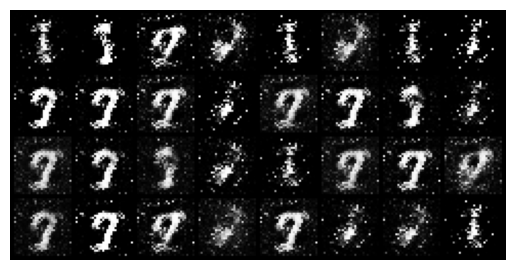

Generator loss: 1.9296 	 Discriminator loss: 0.2505


epoch: 10/25: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


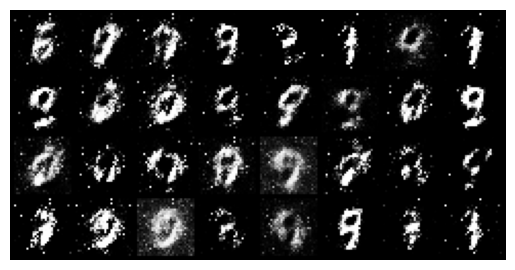

Generator loss: 2.4369 	 Discriminator loss: 0.2605


epoch: 15/25: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s] 


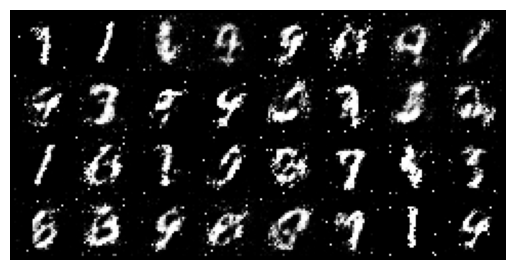

Generator loss: 1.6060 	 Discriminator loss: 0.3901


epoch: 20/25: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s] 


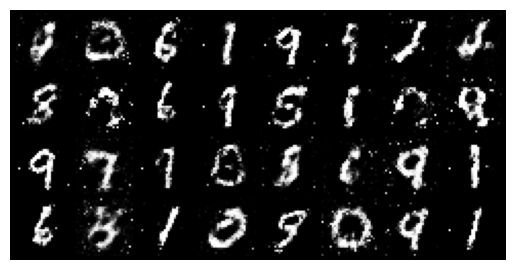

Generator loss: 0.8442 	 Discriminator loss: 0.5545


epoch: 25/25: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s] 


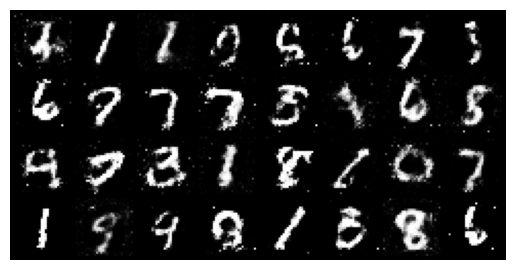

Generator loss: 0.9241 	 Discriminator loss: 0.5081


In [27]:
# Start a training loop
for epoch in range(n_epochs):

    # Cycle through the data in batches of batch_sz -> defaults to 128
    for real_X, _ in tqdm(X_train_loader, desc=f'epoch: {epoch + 1}/{n_epochs}'):

        # Move the real_X to device
        real_X = real_X.to(device=device)

        # Get the batch size of the images, by looking at the first dimension
        b = real_X.size(dim=0)

        # Reshape the real_X from -1, 1, 28, 28 -> (batch_size, channels, height, width) to -1, 784 -> (batch_sz, features)
        # Remember, we reshape because we are working with linear layers rather than conv2d
        real_X = real_X.view(b, -1)
        
        # Create The real and fake labels for each batch
        real_y = torch.ones(size=(b, 1), device=device)
        fake_y = torch.zeros(size=(b, 1), device=device)

        # Create z (noise) for the generator
        z = torch.randn(size=(b, z_dim), device=device)
        
        # ----- Start off by using the generator -----
        g_optimizer.zero_grad(set_to_none=True)

        # Pass the fake image through the generator
        fake_img = g_model(z)

        # Get the discriminator to predict if the fake image is real or not
        d_model_out = d_model(fake_img)

        # Calculate the loss
        gen_loss = adversarial_loss(d_model_out, real_y)

        # Perform backpropagation
        gen_loss.backward()

        # update the model parameters
        g_optimizer.step()

        # ----- Generator End -----


        # ----- Discriminator starts here -----
        d_optimizer.zero_grad(set_to_none=True)
        
        # Pass the real image through the discriminator 
        d_real_out = d_model(real_X)

        # Calculate the loss on the real images
        d_real_loss = adversarial_loss(input=d_real_out, target=real_y)

        # Pass the fake image through the discriminator
        d_fake_out = d_model(fake_img.detach())

        # Calculate the loss on the fake image
        d_fake_loss = adversarial_loss(input=d_fake_out, target=fake_y)

        # get the losses
        d_final_loss = (d_real_loss + d_fake_loss) / 2
        d_final_loss.backward()
        d_optimizer.step()

        # ----- Discriminator ends here -----
        
        #break
    
    # At every 5 epochs, print the loss information as well generate a grid of the images so far.
    # This allows us to visualize the learning process
    # We are able to see how we move from the nose to readable images
    if (epoch + 1) % 5 == 0:
        with torch.inference_mode():
            # Generate a batch of 32 random noise samples 
            z_tmp = torch.randn(size=(32, 100))

            # Pass the noise (fake images) through the trained generator
            fake_img_tmp = g_model(z_tmp.to(device)).view(-1, 1, 28, 28)

            # permute here is used to move the dimensions around so we could visualize the images
            fake_img_grid = make_grid(tensor=fake_img_tmp, normalize=True).permute(dims=(1,2,0))
            plt.imshow(X=fake_img_grid.cpu())     
            plt.axis('off')       
            plt.show()

        print(f'Generator loss: {gen_loss:.4f} \t Discriminator loss: {d_final_loss:.4f}')
        make_grid
    #break

As can be seen above, we were able to generate new images (numbers) from random noise, using a GAN. Think about this from the perspective to generate new faces to bypass biometric solutions. Generating fingerprints data to bypass biometric solutions, or even generating new data to evade your ML model, etc.

You should notice that from above, we moved from random noise, all the way to readable images. Obviously, if we train for a longer period more than 25 epochs, we would expect that these numbers would be even cleaner. However, considering where we started from (random noise), it is fair for the purpose of this lab, that we have the understanding now of where this is heading.   

At this point, one can *discard* the discriminator and only save the generator. The generator is what is needed for generating future seemingly real (actually fake) data from just random noise.   


### Step 11:  

In [28]:
# Let's now save our model
torch.jit.script(obj=g_model).save(f='/tmp/generator.pth')

# Verify the file has been saved
!ls /tmp/generator.pth

/tmp/generator.pth


With the model saved, we can just share it with our applications teams and load in our desired application.  

### Step 12:  

In [29]:
# Load the model to generate real looking images
loaded_generator = torch.jit.load(f='/tmp/generator.pth', map_location=device)

# Put the generator in eval model
# This step is not as important for us
# While the discriminator has dropout layers the generator does not
# Dropout operates differently during training and inferences
# We are making inference
loaded_generator.eval()

RecursiveScriptModule(
  original_name=Generator
  (gen_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LeakyReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=LeakyReLU)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=LeakyReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=Tanh)
  )
)

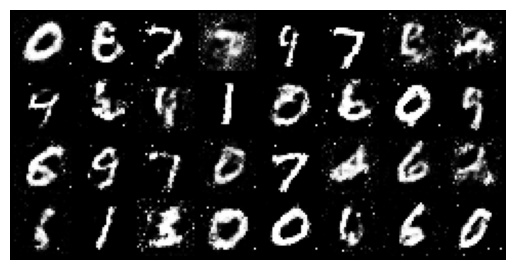

In [30]:
# Generate some new images and visualize them, using the loaded generator model
# Run this cell a few times to see different outputs
with torch.inference_mode():
    # Generate random noise
    new_z = torch.randn(size=(32, 100), device=device)

    # pass that noise through the generator 
    new_fake_img = loaded_generator(new_z).view(-1, 1, 28, 28)
    fake_img_grid = make_grid(tensor=new_fake_img, normalize=True).permute(dims=(1,2,0))
    plt.imshow(X=fake_img_grid.cpu())     
    plt.axis('off')       
    plt.show()

This works but can we improve this. Let's try with a DCGAN.

### That's it for our vanilla GAN! 

### Lab Takeaways   
- We were able to build a Generative Adversarial Network, using linear/dense layers    
- We learnt that a GAN consists of two components, a generator and a discriminator      
- We learnt that a the generator, is responsibile for creating the fake input/images/videos, etc.    
- We learnt that the discriminator is responsible for detecting those fake input/images/videos, etc.    
- We also got a a hint that while this works, there may be a better approach   